In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
import lightgbm
import logging
# from src.utils import merge_simultanous_rows, save_to_blob, data_process

In [3]:
min_max_mat=np.array([[2175,2175,1,1],[3398.25,3396.5,82120,70494]])

In [4]:
min_max_mat.shape

(2, 4)

In [5]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(min_max_mat)

MinMaxScaler()

In [6]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs":10,
    "lr": 0.00010000,
    "time_steps": 100
}

iter_changes = "dropout_layers_0.4_0.4"

# INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/inputs"
# OUTPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/outputs/lstm_best_7-3-19_12AM/"+iter_changes
OUTPUT_PATH = '../data/models_mp_10000_0.0005'
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

In [7]:
def build_timeseries(mat, labels, steps = TIME_STEPS):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - steps
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, steps, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
#     for i in tqdm_notebook(range(dim_0)):
    for i in range(dim_0):
        x[i] = mat[i:steps+i]
        y[i] = labels[steps+i]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [8]:
def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [9]:
def getWeights(d, size):
    w=[1]*size
    for k in range(1, size):
        w[k] = -w[k-1]/ k * (d - k + 1)
    
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def getWeights_FFD(d=0.1, thres=1e-5):    
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_)
        k+=1
    return np.array(w[::-1]).reshape(-1,1)

def fracDiff(series, d, thres=0.1):
    w = getWeights(d, series.shape[0])
    w_ = np.cumsum(abs(w))
    w_ /= w[-1]
    skip = w_[w_>thres].shape[0]
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc=seriesF.index[iloc]
            if not np.isfinite(series.loc[loc, name]):
                continue
            df_[loc] = np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc][0.0])
        df[name]= df_.copy(deep=True)
        
    df = pd.concat(df, axis=1)
    return df

def fracDiff_FFD(series, d, thres=1e-5):
    # this function is not defined, read text to see what exactly he was trying to do
    w = getWeights_FFD(d, thres)
    #w = getWeights_FFD(d, thres)
    width = len(w) - 1
    df = {}
    print(width)
    
    for name in series.columns:
        print(name)
        seriesF=series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series(dtype='float64') 
        print(df_.shape)
        print(seriesF.shape[0])
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1-width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue # exclude NAs 
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
            print(df_.shape)
            df[name] = df_.copy(deep=True) 
            print (df[name].head(5))
            
    df = pd.concat(df, axis=1)
    
    return df

In [10]:
bars_folder = '../data/labels_mp_1000_0.0005/'
OUTPUT_PATH = "../data/outputs_1000_0.0005/"
files = sorted(os.listdir(bars_folder))
files = [f'{bars_folder}{f}' for f in files]
files[0]

'../data/labels_mp_1000_0.0005/bars_2017-01-06-mt.csv'

In [11]:
# df_1day_bars = pd.read_csv(files[0])
# base_train_cols = ['Bid Price', 'Ask Price', 'Bid Size', 'Ask Size']
# label_col = ['long_label']
# # Adding new columns
# df_1day_bars["BidAskRatio"] = (
#     df_1day_bars["Bid Size"] / df_1day_bars["Ask Size"]
# )
# new_train_cols = [f"{col}_diff" for col in base_train_cols]
# df_1day_bars[new_train_cols] = df_1day_bars[base_train_cols].diff()
# train_cols = base_train_cols+new_train_cols+['dailyVolatility']
# print("shape of data after adding new cols: {}".format(df_1day_bars.shape))
# print(train_cols)
# df_1day_bars.head()

In [12]:
# a = df_1day_bars.diff()
# a.dropna(inplace = True, axis=0)
# a

In [14]:
# for col in df_1day_bars.columns:
#     print(col)

In [19]:
def run(mini_batch):
    #     print(f'run method start: {__file__}, run({mini_batch})')
    resultList = []
    X_full = np.array([])
    y_full = np.array([])

    # for raw_file_name in mini_batch:
    for raw_file_name in tqdm(mini_batch):
        # read each file
        print("******  Processing {}".format(os.path.basename(raw_file_name)))
        df_1day_bars = pd.read_csv(raw_file_name)
        print("original shape of data: {}".format(df_1day_bars.shape))
        if df_1day_bars.shape[0] == 0:
            resultList.append("{}, {}".format(0, os.path.basename(raw_file_name)))
            return resultList
        #         print(df_1day_bars.dtypes)
        date_string = df_1day_bars.loc[0, "Date-Time"][:10]
        # remove unwanted colls
        base_train_cols = ["Bid Price", "Ask Price", "Bid Size", "Ask Size"]
        label_col = ["long_label"]

        # Adding new columns
        df_1day_bars["BidAskRatio"] = (
            df_1day_bars["Bid Size"] / df_1day_bars["Ask Size"]
        )
        new_train_cols = [f"{col}_diff" for col in base_train_cols]
        df_1day_bars[new_train_cols] = df_1day_bars[base_train_cols].diff()
        train_cols = base_train_cols + new_train_cols + ["BidAskRatio"]
        # df_1day_bars[[f'{col}_fd' for col in train_cols]] = fracDiff_FFD(df_1day_bars[train_cols], 0.35)
        df_1day_bars = df_1day_bars[train_cols + label_col]
        # remove rows with NA values
        df_1day_bars.dropna(inplace=True, axis=0)
        print(
            "shape of data after removing unwanted rows/cols: {}".format(
                df_1day_bars.shape
            )
        )
        print("included columns in the training data: {}".format(train_cols))

        x = df_1day_bars.loc[:, train_cols].values
        y = df_1day_bars.loc[:, label_col].values
        min_max_scaler = MinMaxScaler()
        x_s = min_max_scaler.fit_transform(x)
        print(
            "Deleting unused dataframes of total size(KB)",
            (sys.getsizeof(df_1day_bars)) // 1024,
        )
        del df_1day_bars
        print(
            "Are any NaNs present in train/test matrices?",
            np.isnan(x_s).any(),
            np.isnan(x_s).any(),
        )

        x_t, y_t = build_timeseries(x_s, y, TIME_STEPS)
        print("Batch trimmed size", x_t.shape, y_t.shape)
        if len(X_full) == 0:
            X_full = np.array([]).reshape(0, x_t.shape[1], x_t.shape[2])
            print("initiating X_full data. Shape: {}".format(X_full.shape))

        X_full = np.append(X_full, x_t, axis=0)
        y_full = np.append(y_full, y_t, axis=0)
        print("full sizes:", X_full.shape, y_full.shape)

    return X_full, y_full
x_full, y_full = run(files[0:5])

 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:00, 13.54it/s]

******  Processing bars_2017-01-06-mt.csv
original shape of data: (1523, 17)
shape of data after removing unwanted rows/cols: (1522, 10)
included columns in the training data: ['Bid Price', 'Ask Price', 'Bid Size', 'Ask Size', 'Bid Price_diff', 'Ask Price_diff', 'Bid Size_diff', 'Ask Size_diff', 'BidAskRatio']
Deleting unused dataframes of total size(KB) 130
Are any NaNs present in train/test matrices? False False
dim_0 1422
length of time-series i/o (1422, 100, 9) (1422,)
Batch trimmed size (1422, 100, 9) (1422,)
initiating X_full data. Shape: (0, 100, 9)
full sizes: (1422, 100, 9) (1422,)
******  Processing bars_2017-01-09-mt.csv
original shape of data: (1030, 17)
shape of data after removing unwanted rows/cols: (1029, 10)
included columns in the training data: ['Bid Price', 'Ask Price', 'Bid Size', 'Ask Size', 'Bid Price_diff', 'Ask Price_diff', 'Bid Size_diff', 'Ask Size_diff', 'BidAskRatio']
Deleting unused dataframes of total size(KB) 88
Are any NaNs present in train/test matrice

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:00<00:00, 12.54it/s]

 (3554, 100, 9) (3554,)
******  Processing bars_2017-01-11-mt.csv
original shape of data: (1731, 17)
shape of data after removing unwanted rows/cols: (1730, 10)
included columns in the training data: ['Bid Price', 'Ask Price', 'Bid Size', 'Ask Size', 'Bid Price_diff', 'Ask Price_diff', 'Bid Size_diff', 'Ask Size_diff', 'BidAskRatio']
Deleting unused dataframes of total size(KB) 148
Are any NaNs present in train/test matrices? False False
dim_0 1630
length of time-series i/o (1630, 100, 9) (1630,)
Batch trimmed size (1630, 100, 9) (1630,)
full sizes: (5184, 100, 9) (5184,)
******  Processing bars_2017-01-12-mt.csv
original shape of data: (1725, 17)
shape of data after removing unwanted rows/cols: (1724, 10)
included columns in the training data: ['Bid Price', 'Ask Price', 'Bid Size', 'Ask Size', 'Bid Price_diff', 'Ask Price_diff', 'Bid Size_diff', 'Ask Size_diff', 'BidAskRatio']
Deleting unused dataframes of total size(KB) 148
Are any NaNs present in train/test matrices? False False
dim

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.27it/s]

 (6808, 100, 9) (6808,)


In [105]:
def run(mini_batch):
#     print(f'run method start: {__file__}, run({mini_batch})')
    resultList = []
    x_full =np.array([]).reshape(0,100,4)
    y_full =np.array([])
    
    # for raw_file_name in mini_batch:
    for raw_file_name in tqdm_notebook(mini_batch):
        # read each file
        print("******  Processing {}".format(os.path.basename(raw_file_name)))
        df_1day_bars = pd.read_csv(raw_file_name)
        print("original shape of data: {}".format(df_1day_bars.shape))
        if df_1day_bars.shape[0] == 0:
            resultList.append("{}, {}".format(0, os.path.basename(raw_file_name)))
            return resultList
#         print(df_1day_bars.dtypes)
        date_string = df_1day_bars.loc[0, 'Date-Time'][:10]
        # remove unwanted colls

        train_cols = ['Bid Price', 'Ask Price', 'Bid Size', 'Ask Size']
        label_col = ['long_label']
#         df_1day_bars = df_1day_bars.loc[:,train_cols]
#         print("shape of data after removing unwanted cols: {}".format(df_1day_bars.shape))
        x = df_1day_bars.loc[:,train_cols].values
        y = df_1day_bars.loc[:,label_col].values
#         min_max_scaler = MinMaxScaler()
        x_s = min_max_scaler.transform(x)
        print("Deleting unused dataframes of total size(KB)",(sys.getsizeof(df_1day_bars))//1024)
        del df_1day_bars
        print("Are any NaNs present in train/test matrices?",np.isnan(x_s).any(), np.isnan(x_s).any())
        x_t, y_t = build_timeseries(x_s, y, TIME_STEPS)
#         x_t = trim_dataset(x_t, BATCH_SIZE)
#         y_t = trim_dataset(y_t, BATCH_SIZE)
        print("Batch trimmed size",x_t.shape, y_t.shape)
#         file_path_x = os.path.join('../data/samples_mp_1000_0.0005/',f'{date_string}_x.npy')
#         file_path_y = os.path.join('../data/samples_mp_1000_0.0005/',f'{date_string}_y.npy')
#         with open(file_path_x, 'wb') as f:
#             np.save(f, x_t)
#         with open(file_path_y, 'wb') as f:
#             np.save(f, y_t)
        x_full = np.append(x_full,x_t,axis=0)
        y_full = np.append(y_full,y_t,axis=0)
        print("full sizes:", x_full.shape, y_full.shape)
        
    return x_full, y_full
x_full, y_full = run([files[10]])

******  Processing bars_2017-01-23-mt.csv
original shape of data: (1406, 17)
Deleting unused dataframes of total size(KB) 466
Are any NaNs present in train/test matrices? False False
dim_0 1306
length of time-series i/o (1306, 100, 4) (1306,)
Batch trimmed size (1306, 100, 4) (1306,)
full sizes: (1306, 100, 4) (1306,)



In [113]:
x_full, y_full = run(files)

******  Processing bars_2017-01-06-mt.csv
original shape of data: (1523, 17)
Deleting unused dataframes of total size(KB) 505
Are any NaNs present in train/test matrices? False False
dim_0 1423
length of time-series i/o (1423, 100, 4) (1423,)
Batch trimmed size (1423, 100, 4) (1423,)
full sizes: (1423, 100, 4) (1423,)
******  Processing bars_2017-01-09-mt.csv
original shape of data: (1030, 17)
Deleting unused dataframes of total size(KB) 342
Are any NaNs present in train/test matrices? False False
dim_0 930
length of time-series i/o (930, 100, 4) (930,)
Batch trimmed size (930, 100, 4) (930,)
full sizes: (2353, 100, 4) (2353,)
******  Processing bars_2017-01-10-mt.csv
original shape of data: (1304, 17)
Deleting unused dataframes of total size(KB) 433
Are any NaNs present in train/test matrices? False False
dim_0 1204
length of time-series i/o (1204, 100, 4) (1204,)
Batch trimmed size (1204, 100, 4) (1204,)
full sizes: (3557, 100, 4) (3557,)
******  Processing bars_2017-01-11-mt.csv
ori

full sizes: (32614, 100, 4) (32614,)
******  Processing bars_2017-02-14-mt.csv
original shape of data: (1377, 17)
Deleting unused dataframes of total size(KB) 457
Are any NaNs present in train/test matrices? False False
dim_0 1277
length of time-series i/o (1277, 100, 4) (1277,)
Batch trimmed size (1277, 100, 4) (1277,)
full sizes: (33891, 100, 4) (33891,)
******  Processing bars_2017-02-15-mt.csv
original shape of data: (1492, 17)
Deleting unused dataframes of total size(KB) 495
Are any NaNs present in train/test matrices? False False
dim_0 1392
length of time-series i/o (1392, 100, 4) (1392,)
Batch trimmed size (1392, 100, 4) (1392,)
full sizes: (35283, 100, 4) (35283,)
******  Processing bars_2017-02-16-mt.csv
original shape of data: (1718, 17)
Deleting unused dataframes of total size(KB) 570
Are any NaNs present in train/test matrices? False False
dim_0 1618
length of time-series i/o (1618, 100, 4) (1618,)
Batch trimmed size (1618, 100, 4) (1618,)
full sizes: (36901, 100, 4) (36901

full sizes: (67265, 100, 4) (67265,)
******  Processing bars_2017-03-23-mt.csv
original shape of data: (1624, 17)
Deleting unused dataframes of total size(KB) 539
Are any NaNs present in train/test matrices? False False
dim_0 1524
length of time-series i/o (1524, 100, 4) (1524,)
Batch trimmed size (1524, 100, 4) (1524,)
full sizes: (68789, 100, 4) (68789,)
******  Processing bars_2017-03-24-mt.csv
original shape of data: (1538, 17)
Deleting unused dataframes of total size(KB) 510
Are any NaNs present in train/test matrices? False False
dim_0 1438
length of time-series i/o (1438, 100, 4) (1438,)
Batch trimmed size (1438, 100, 4) (1438,)
full sizes: (70227, 100, 4) (70227,)
******  Processing bars_2017-03-27-mt.csv
original shape of data: (1542, 17)
Deleting unused dataframes of total size(KB) 512
Are any NaNs present in train/test matrices? False False
dim_0 1442
length of time-series i/o (1442, 100, 4) (1442,)
Batch trimmed size (1442, 100, 4) (1442,)
full sizes: (71669, 100, 4) (71669

full sizes: (101557, 100, 4) (101557,)
******  Processing bars_2017-05-01-mt.csv
original shape of data: (893, 17)
Deleting unused dataframes of total size(KB) 296
Are any NaNs present in train/test matrices? False False
dim_0 793
length of time-series i/o (793, 100, 4) (793,)
Batch trimmed size (793, 100, 4) (793,)
full sizes: (102350, 100, 4) (102350,)
******  Processing bars_2017-05-02-mt.csv
original shape of data: (941, 17)
Deleting unused dataframes of total size(KB) 312
Are any NaNs present in train/test matrices? False False
dim_0 841
length of time-series i/o (841, 100, 4) (841,)
Batch trimmed size (841, 100, 4) (841,)
full sizes: (103191, 100, 4) (103191,)
******  Processing bars_2017-05-03-mt.csv
original shape of data: (1073, 17)
Deleting unused dataframes of total size(KB) 356
Are any NaNs present in train/test matrices? False False
dim_0 973
length of time-series i/o (973, 100, 4) (973,)
Batch trimmed size (973, 100, 4) (973,)
full sizes: (104164, 100, 4) (104164,)
******

full sizes: (131532, 100, 4) (131532,)
******  Processing bars_2017-06-07-mt.csv
original shape of data: (1241, 17)
Deleting unused dataframes of total size(KB) 412
Are any NaNs present in train/test matrices? False False
dim_0 1141
length of time-series i/o (1141, 100, 4) (1141,)
Batch trimmed size (1141, 100, 4) (1141,)
full sizes: (132673, 100, 4) (132673,)
******  Processing bars_2017-06-08-mt.csv
original shape of data: (1047, 17)
Deleting unused dataframes of total size(KB) 347
Are any NaNs present in train/test matrices? False False
dim_0 947
length of time-series i/o (947, 100, 4) (947,)
Batch trimmed size (947, 100, 4) (947,)
full sizes: (133620, 100, 4) (133620,)
******  Processing bars_2017-06-09-mt.csv
original shape of data: (1418, 17)
Deleting unused dataframes of total size(KB) 470
Are any NaNs present in train/test matrices? False False
dim_0 1318
length of time-series i/o (1318, 100, 4) (1318,)
Batch trimmed size (1318, 100, 4) (1318,)
full sizes: (134938, 100, 4) (134

full sizes: (162492, 100, 4) (162492,)
******  Processing bars_2017-07-14-mt.csv
original shape of data: (1055, 17)
Deleting unused dataframes of total size(KB) 350
Are any NaNs present in train/test matrices? False False
dim_0 955
length of time-series i/o (955, 100, 4) (955,)
Batch trimmed size (955, 100, 4) (955,)
full sizes: (163447, 100, 4) (163447,)
******  Processing bars_2017-07-17-mt.csv
original shape of data: (856, 17)
Deleting unused dataframes of total size(KB) 284
Are any NaNs present in train/test matrices? False False
dim_0 756
length of time-series i/o (756, 100, 4) (756,)
Batch trimmed size (756, 100, 4) (756,)
full sizes: (164203, 100, 4) (164203,)
******  Processing bars_2017-07-18-mt.csv
original shape of data: (1062, 17)
Deleting unused dataframes of total size(KB) 352
Are any NaNs present in train/test matrices? False False
dim_0 962
length of time-series i/o (962, 100, 4) (962,)
Batch trimmed size (962, 100, 4) (962,)
full sizes: (165165, 100, 4) (165165,)
*****

full sizes: (192526, 100, 4) (192526,)
******  Processing bars_2017-08-21-mt.csv
original shape of data: (1308, 17)
Deleting unused dataframes of total size(KB) 434
Are any NaNs present in train/test matrices? False False
dim_0 1208
length of time-series i/o (1208, 100, 4) (1208,)
Batch trimmed size (1208, 100, 4) (1208,)
full sizes: (193734, 100, 4) (193734,)
******  Processing bars_2017-08-22-mt.csv
original shape of data: (1350, 17)
Deleting unused dataframes of total size(KB) 448
Are any NaNs present in train/test matrices? False False
dim_0 1250
length of time-series i/o (1250, 100, 4) (1250,)
Batch trimmed size (1250, 100, 4) (1250,)
full sizes: (194984, 100, 4) (194984,)
******  Processing bars_2017-08-23-mt.csv
original shape of data: (1224, 17)
Deleting unused dataframes of total size(KB) 406
Are any NaNs present in train/test matrices? False False
dim_0 1124
length of time-series i/o (1124, 100, 4) (1124,)
Batch trimmed size (1124, 100, 4) (1124,)
full sizes: (196108, 100, 4)

full sizes: (221032, 100, 4) (221032,)
******  Processing bars_2017-09-27-mt.csv
original shape of data: (1561, 17)
Deleting unused dataframes of total size(KB) 518
Are any NaNs present in train/test matrices? False False
dim_0 1461
length of time-series i/o (1461, 100, 4) (1461,)
Batch trimmed size (1461, 100, 4) (1461,)
full sizes: (222493, 100, 4) (222493,)
******  Processing bars_2017-09-28-mt.csv
original shape of data: (1104, 17)
Deleting unused dataframes of total size(KB) 366
Are any NaNs present in train/test matrices? False False
dim_0 1004
length of time-series i/o (1004, 100, 4) (1004,)
Batch trimmed size (1004, 100, 4) (1004,)
full sizes: (223497, 100, 4) (223497,)
******  Processing bars_2017-09-29-mt.csv
original shape of data: (1282, 17)
Deleting unused dataframes of total size(KB) 425
Are any NaNs present in train/test matrices? False False
dim_0 1182
length of time-series i/o (1182, 100, 4) (1182,)
Batch trimmed size (1182, 100, 4) (1182,)
full sizes: (224679, 100, 4)

full sizes: (247305, 100, 4) (247305,)
******  Processing bars_2017-11-02-mt.csv
original shape of data: (1213, 17)
Deleting unused dataframes of total size(KB) 402
Are any NaNs present in train/test matrices? False False
dim_0 1113
length of time-series i/o (1113, 100, 4) (1113,)
Batch trimmed size (1113, 100, 4) (1113,)
full sizes: (248418, 100, 4) (248418,)
******  Processing bars_2017-11-03-mt.csv
original shape of data: (952, 17)
Deleting unused dataframes of total size(KB) 316
Are any NaNs present in train/test matrices? False False
dim_0 852
length of time-series i/o (852, 100, 4) (852,)
Batch trimmed size (852, 100, 4) (852,)
full sizes: (249270, 100, 4) (249270,)
******  Processing bars_2017-11-06-mt.csv
original shape of data: (800, 17)
Deleting unused dataframes of total size(KB) 265
Are any NaNs present in train/test matrices? False False
dim_0 700
length of time-series i/o (700, 100, 4) (700,)
Batch trimmed size (700, 100, 4) (700,)
full sizes: (249970, 100, 4) (249970,)
*

full sizes: (277570, 100, 4) (277570,)
******  Processing bars_2017-12-11-mt.csv
original shape of data: (712, 17)
Deleting unused dataframes of total size(KB) 236
Are any NaNs present in train/test matrices? False False
dim_0 612
length of time-series i/o (612, 100, 4) (612,)
Batch trimmed size (612, 100, 4) (612,)
full sizes: (278182, 100, 4) (278182,)
******  Processing bars_2017-12-12-mt.csv
original shape of data: (943, 17)
Deleting unused dataframes of total size(KB) 313
Are any NaNs present in train/test matrices? False False
dim_0 843
length of time-series i/o (843, 100, 4) (843,)
Batch trimmed size (843, 100, 4) (843,)
full sizes: (279025, 100, 4) (279025,)
******  Processing bars_2017-12-13-mt.csv
original shape of data: (1000, 17)
Deleting unused dataframes of total size(KB) 332
Are any NaNs present in train/test matrices? False False
dim_0 900
length of time-series i/o (900, 100, 4) (900,)
Batch trimmed size (900, 100, 4) (900,)
full sizes: (279925, 100, 4) (279925,)
******

full sizes: (301074, 100, 4) (301074,)
******  Processing bars_2018-01-19-mt.csv
original shape of data: (1228, 17)
Deleting unused dataframes of total size(KB) 407
Are any NaNs present in train/test matrices? False False
dim_0 1128
length of time-series i/o (1128, 100, 4) (1128,)
Batch trimmed size (1128, 100, 4) (1128,)
full sizes: (302202, 100, 4) (302202,)
******  Processing bars_2018-01-22-mt.csv
original shape of data: (1092, 17)
Deleting unused dataframes of total size(KB) 362
Are any NaNs present in train/test matrices? False False
dim_0 992
length of time-series i/o (992, 100, 4) (992,)
Batch trimmed size (992, 100, 4) (992,)
full sizes: (303194, 100, 4) (303194,)
******  Processing bars_2018-01-23-mt.csv
original shape of data: (1186, 17)
Deleting unused dataframes of total size(KB) 393
Are any NaNs present in train/test matrices? False False
dim_0 1086
length of time-series i/o (1086, 100, 4) (1086,)
Batch trimmed size (1086, 100, 4) (1086,)
full sizes: (304280, 100, 4) (304

full sizes: (348430, 100, 4) (348430,)
******  Processing bars_2018-02-27-mt.csv
original shape of data: (1687, 17)
Deleting unused dataframes of total size(KB) 560
Are any NaNs present in train/test matrices? False False
dim_0 1587
length of time-series i/o (1587, 100, 4) (1587,)
Batch trimmed size (1587, 100, 4) (1587,)
full sizes: (350017, 100, 4) (350017,)
******  Processing bars_2018-02-28-mt.csv
original shape of data: (1787, 17)
Deleting unused dataframes of total size(KB) 593
Are any NaNs present in train/test matrices? False False
dim_0 1687
length of time-series i/o (1687, 100, 4) (1687,)
Batch trimmed size (1687, 100, 4) (1687,)
full sizes: (351704, 100, 4) (351704,)
******  Processing bars_2018-03-01-mt.csv
original shape of data: (2706, 17)
Deleting unused dataframes of total size(KB) 898
Are any NaNs present in train/test matrices? False False
dim_0 2606
length of time-series i/o (2606, 100, 4) (2606,)
Batch trimmed size (2606, 100, 4) (2606,)
full sizes: (354310, 100, 4)

full sizes: (392022, 100, 4) (392022,)
******  Processing bars_2018-04-05-mt.csv
original shape of data: (1720, 17)
Deleting unused dataframes of total size(KB) 571
Are any NaNs present in train/test matrices? False False
dim_0 1620
length of time-series i/o (1620, 100, 4) (1620,)
Batch trimmed size (1620, 100, 4) (1620,)
full sizes: (393642, 100, 4) (393642,)
******  Processing bars_2018-04-06-mt.csv
original shape of data: (2302, 17)
Deleting unused dataframes of total size(KB) 764
Are any NaNs present in train/test matrices? False False
dim_0 2202
length of time-series i/o (2202, 100, 4) (2202,)
Batch trimmed size (2202, 100, 4) (2202,)
full sizes: (395844, 100, 4) (395844,)
******  Processing bars_2018-04-09-mt.csv
original shape of data: (1794, 17)
Deleting unused dataframes of total size(KB) 595
Are any NaNs present in train/test matrices? False False
dim_0 1694
length of time-series i/o (1694, 100, 4) (1694,)
Batch trimmed size (1694, 100, 4) (1694,)
full sizes: (397538, 100, 4)

full sizes: (427848, 100, 4) (427848,)
******  Processing bars_2018-05-11-mt.csv
original shape of data: (997, 17)
Deleting unused dataframes of total size(KB) 331
Are any NaNs present in train/test matrices? False False
dim_0 897
length of time-series i/o (897, 100, 4) (897,)
Batch trimmed size (897, 100, 4) (897,)
full sizes: (428745, 100, 4) (428745,)
******  Processing bars_2018-05-14-mt.csv
original shape of data: (897, 17)
Deleting unused dataframes of total size(KB) 297
Are any NaNs present in train/test matrices? False False
dim_0 797
length of time-series i/o (797, 100, 4) (797,)
Batch trimmed size (797, 100, 4) (797,)
full sizes: (429542, 100, 4) (429542,)
******  Processing bars_2018-05-15-mt.csv
original shape of data: (1486, 17)
Deleting unused dataframes of total size(KB) 493
Are any NaNs present in train/test matrices? False False
dim_0 1386
length of time-series i/o (1386, 100, 4) (1386,)
Batch trimmed size (1386, 100, 4) (1386,)
full sizes: (430928, 100, 4) (430928,)
*

full sizes: (453372, 100, 4) (453372,)
******  Processing bars_2018-06-19-mt.csv
original shape of data: (1527, 17)
Deleting unused dataframes of total size(KB) 507
Are any NaNs present in train/test matrices? False False
dim_0 1427
length of time-series i/o (1427, 100, 4) (1427,)
Batch trimmed size (1427, 100, 4) (1427,)
full sizes: (454799, 100, 4) (454799,)
******  Processing bars_2018-06-20-mt.csv
original shape of data: (1031, 17)
Deleting unused dataframes of total size(KB) 342
Are any NaNs present in train/test matrices? False False
dim_0 931
length of time-series i/o (931, 100, 4) (931,)
Batch trimmed size (931, 100, 4) (931,)
full sizes: (455730, 100, 4) (455730,)
******  Processing bars_2018-06-21-mt.csv
original shape of data: (1442, 17)
Deleting unused dataframes of total size(KB) 478
Are any NaNs present in train/test matrices? False False
dim_0 1342
length of time-series i/o (1342, 100, 4) (1342,)
Batch trimmed size (1342, 100, 4) (1342,)
full sizes: (457072, 100, 4) (457

full sizes: (481896, 100, 4) (481896,)
******  Processing bars_2018-07-26-mt.csv
original shape of data: (971, 17)
Deleting unused dataframes of total size(KB) 322
Are any NaNs present in train/test matrices? False False
dim_0 871
length of time-series i/o (871, 100, 4) (871,)
Batch trimmed size (871, 100, 4) (871,)
full sizes: (482767, 100, 4) (482767,)
******  Processing bars_2018-07-27-mt.csv
original shape of data: (1431, 17)
Deleting unused dataframes of total size(KB) 475
Are any NaNs present in train/test matrices? False False
dim_0 1331
length of time-series i/o (1331, 100, 4) (1331,)
Batch trimmed size (1331, 100, 4) (1331,)
full sizes: (484098, 100, 4) (484098,)
******  Processing bars_2018-07-30-mt.csv
original shape of data: (1145, 17)
Deleting unused dataframes of total size(KB) 380
Are any NaNs present in train/test matrices? False False
dim_0 1045
length of time-series i/o (1045, 100, 4) (1045,)
Batch trimmed size (1045, 100, 4) (1045,)
full sizes: (485143, 100, 4) (4851

full sizes: (506830, 100, 4) (506830,)
******  Processing bars_2018-08-31-mt.csv
original shape of data: (1202, 17)
Deleting unused dataframes of total size(KB) 399
Are any NaNs present in train/test matrices? False False
dim_0 1102
length of time-series i/o (1102, 100, 4) (1102,)
Batch trimmed size (1102, 100, 4) (1102,)
full sizes: (507932, 100, 4) (507932,)
******  Processing bars_2018-09-04-mt.csv
original shape of data: (1445, 17)
Deleting unused dataframes of total size(KB) 479
Are any NaNs present in train/test matrices? False False
dim_0 1345
length of time-series i/o (1345, 100, 4) (1345,)
Batch trimmed size (1345, 100, 4) (1345,)
full sizes: (509277, 100, 4) (509277,)
******  Processing bars_2018-09-05-mt.csv
original shape of data: (1558, 17)
Deleting unused dataframes of total size(KB) 517
Are any NaNs present in train/test matrices? False False
dim_0 1458
length of time-series i/o (1458, 100, 4) (1458,)
Batch trimmed size (1458, 100, 4) (1458,)
full sizes: (510735, 100, 4)

full sizes: (538459, 100, 4) (538459,)
******  Processing bars_2018-10-09-mt.csv
original shape of data: (1724, 17)
Deleting unused dataframes of total size(KB) 572
Are any NaNs present in train/test matrices? False False
dim_0 1624
length of time-series i/o (1624, 100, 4) (1624,)
Batch trimmed size (1624, 100, 4) (1624,)
full sizes: (540083, 100, 4) (540083,)
******  Processing bars_2018-10-10-mt.csv
original shape of data: (3544, 17)
Deleting unused dataframes of total size(KB) 1176
Are any NaNs present in train/test matrices? False False
dim_0 3444
length of time-series i/o (3444, 100, 4) (3444,)
Batch trimmed size (3444, 100, 4) (3444,)
full sizes: (543527, 100, 4) (543527,)
******  Processing bars_2018-10-11-mt.csv
original shape of data: (3802, 17)
Deleting unused dataframes of total size(KB) 1262
Are any NaNs present in train/test matrices? False False
dim_0 3702
length of time-series i/o (3702, 100, 4) (3702,)
Batch trimmed size (3702, 100, 4) (3702,)
full sizes: (547229, 100, 

full sizes: (592375, 100, 4) (592375,)
******  Processing bars_2018-11-14-mt.csv
original shape of data: (2244, 17)
Deleting unused dataframes of total size(KB) 745
Are any NaNs present in train/test matrices? False False
dim_0 2144
length of time-series i/o (2144, 100, 4) (2144,)
Batch trimmed size (2144, 100, 4) (2144,)
full sizes: (594519, 100, 4) (594519,)
******  Processing bars_2018-11-15-mt.csv
original shape of data: (2300, 17)
Deleting unused dataframes of total size(KB) 763
Are any NaNs present in train/test matrices? False False
dim_0 2200
length of time-series i/o (2200, 100, 4) (2200,)
Batch trimmed size (2200, 100, 4) (2200,)
full sizes: (596719, 100, 4) (596719,)
******  Processing bars_2018-11-16-mt.csv
original shape of data: (1749, 17)
Deleting unused dataframes of total size(KB) 580
Are any NaNs present in train/test matrices? False False
dim_0 1649
length of time-series i/o (1649, 100, 4) (1649,)
Batch trimmed size (1649, 100, 4) (1649,)
full sizes: (598368, 100, 4)

full sizes: (641764, 100, 4) (641764,)
******  Processing bars_2018-12-24-mt.csv
original shape of data: (1144, 17)
Deleting unused dataframes of total size(KB) 379
Are any NaNs present in train/test matrices? False False
dim_0 1044
length of time-series i/o (1044, 100, 4) (1044,)
Batch trimmed size (1044, 100, 4) (1044,)
full sizes: (642808, 100, 4) (642808,)
******  Processing bars_2018-12-26-mt.csv
original shape of data: (1871, 17)
Deleting unused dataframes of total size(KB) 621
Are any NaNs present in train/test matrices? False False
dim_0 1771
length of time-series i/o (1771, 100, 4) (1771,)
Batch trimmed size (1771, 100, 4) (1771,)
full sizes: (644579, 100, 4) (644579,)
******  Processing bars_2018-12-27-mt.csv
original shape of data: (2191, 17)
Deleting unused dataframes of total size(KB) 727
Are any NaNs present in train/test matrices? False False
dim_0 2091
length of time-series i/o (2091, 100, 4) (2091,)
Batch trimmed size (2091, 100, 4) (2091,)
full sizes: (646670, 100, 4)

full sizes: (679724, 100, 4) (679724,)
******  Processing bars_2019-02-01-mt.csv
original shape of data: (1333, 17)
Deleting unused dataframes of total size(KB) 442
Are any NaNs present in train/test matrices? False False
dim_0 1233
length of time-series i/o (1233, 100, 4) (1233,)
Batch trimmed size (1233, 100, 4) (1233,)
full sizes: (680957, 100, 4) (680957,)
******  Processing bars_2019-02-04-mt.csv
original shape of data: (989, 17)
Deleting unused dataframes of total size(KB) 328
Are any NaNs present in train/test matrices? False False
dim_0 889
length of time-series i/o (889, 100, 4) (889,)
Batch trimmed size (889, 100, 4) (889,)
full sizes: (681846, 100, 4) (681846,)
******  Processing bars_2019-02-05-mt.csv
original shape of data: (1199, 17)
Deleting unused dataframes of total size(KB) 398
Are any NaNs present in train/test matrices? False False
dim_0 1099
length of time-series i/o (1099, 100, 4) (1099,)
Batch trimmed size (1099, 100, 4) (1099,)
full sizes: (682945, 100, 4) (6829

full sizes: (710115, 100, 4) (710115,)
******  Processing bars_2019-03-12-mt.csv
original shape of data: (1139, 17)
Deleting unused dataframes of total size(KB) 378
Are any NaNs present in train/test matrices? False False
dim_0 1039
length of time-series i/o (1039, 100, 4) (1039,)
Batch trimmed size (1039, 100, 4) (1039,)
full sizes: (711154, 100, 4) (711154,)
******  Processing bars_2019-03-13-mt.csv
original shape of data: (1270, 17)
Deleting unused dataframes of total size(KB) 421
Are any NaNs present in train/test matrices? False False
dim_0 1170
length of time-series i/o (1170, 100, 4) (1170,)
Batch trimmed size (1170, 100, 4) (1170,)
full sizes: (712324, 100, 4) (712324,)
******  Processing bars_2019-03-14-mt.csv
original shape of data: (1057, 17)
Deleting unused dataframes of total size(KB) 351
Are any NaNs present in train/test matrices? False False
dim_0 957
length of time-series i/o (957, 100, 4) (957,)
Batch trimmed size (957, 100, 4) (957,)
full sizes: (713281, 100, 4) (713

full sizes: (740047, 100, 4) (740047,)
******  Processing bars_2019-04-17-mt.csv
original shape of data: (1319, 17)
Deleting unused dataframes of total size(KB) 438
Are any NaNs present in train/test matrices? False False
dim_0 1219
length of time-series i/o (1219, 100, 4) (1219,)
Batch trimmed size (1219, 100, 4) (1219,)
full sizes: (741266, 100, 4) (741266,)
******  Processing bars_2019-04-18-mt.csv
original shape of data: (1231, 17)
Deleting unused dataframes of total size(KB) 408
Are any NaNs present in train/test matrices? False False
dim_0 1131
length of time-series i/o (1131, 100, 4) (1131,)
Batch trimmed size (1131, 100, 4) (1131,)
full sizes: (742397, 100, 4) (742397,)
******  Processing bars_2019-04-22-mt.csv
original shape of data: (666, 17)
Deleting unused dataframes of total size(KB) 221
Are any NaNs present in train/test matrices? False False
dim_0 566
length of time-series i/o (566, 100, 4) (566,)
Batch trimmed size (566, 100, 4) (566,)
full sizes: (742963, 100, 4) (7429

full sizes: (779588, 100, 4) (779588,)
******  Processing bars_2019-05-24-mt.csv
original shape of data: (1085, 17)
Deleting unused dataframes of total size(KB) 360
Are any NaNs present in train/test matrices? False False
dim_0 985
length of time-series i/o (985, 100, 4) (985,)
Batch trimmed size (985, 100, 4) (985,)
full sizes: (780573, 100, 4) (780573,)
******  Processing bars_2019-05-28-mt.csv
original shape of data: (1496, 17)
Deleting unused dataframes of total size(KB) 496
Are any NaNs present in train/test matrices? False False
dim_0 1396
length of time-series i/o (1396, 100, 4) (1396,)
Batch trimmed size (1396, 100, 4) (1396,)
full sizes: (781969, 100, 4) (781969,)
******  Processing bars_2019-05-29-mt.csv
original shape of data: (1995, 17)
Deleting unused dataframes of total size(KB) 662
Are any NaNs present in train/test matrices? False False
dim_0 1895
length of time-series i/o (1895, 100, 4) (1895,)
Batch trimmed size (1895, 100, 4) (1895,)
full sizes: (783864, 100, 4) (783

full sizes: (812808, 100, 4) (812808,)
******  Processing bars_2019-07-02-mt.csv
original shape of data: (1079, 17)
Deleting unused dataframes of total size(KB) 358
Are any NaNs present in train/test matrices? False False
dim_0 979
length of time-series i/o (979, 100, 4) (979,)
Batch trimmed size (979, 100, 4) (979,)
full sizes: (813787, 100, 4) (813787,)
******  Processing bars_2019-07-03-mt.csv
original shape of data: (735, 17)
Deleting unused dataframes of total size(KB) 244
Are any NaNs present in train/test matrices? False False
dim_0 635
length of time-series i/o (635, 100, 4) (635,)
Batch trimmed size (635, 100, 4) (635,)
full sizes: (814422, 100, 4) (814422,)
******  Processing bars_2019-07-05-mt.csv
original shape of data: (1152, 17)
Deleting unused dataframes of total size(KB) 382
Are any NaNs present in train/test matrices? False False
dim_0 1052
length of time-series i/o (1052, 100, 4) (1052,)
Batch trimmed size (1052, 100, 4) (1052,)
full sizes: (815474, 100, 4) (815474,)


full sizes: (845973, 100, 4) (845973,)
******  Processing bars_2019-08-08-mt.csv
original shape of data: (1742, 17)
Deleting unused dataframes of total size(KB) 578
Are any NaNs present in train/test matrices? False False
dim_0 1642
length of time-series i/o (1642, 100, 4) (1642,)
Batch trimmed size (1642, 100, 4) (1642,)
full sizes: (847615, 100, 4) (847615,)
******  Processing bars_2019-08-09-mt.csv
original shape of data: (1831, 17)
Deleting unused dataframes of total size(KB) 608
Are any NaNs present in train/test matrices? False False
dim_0 1731
length of time-series i/o (1731, 100, 4) (1731,)
Batch trimmed size (1731, 100, 4) (1731,)
full sizes: (849346, 100, 4) (849346,)
******  Processing bars_2019-08-12-mt.csv
original shape of data: (1671, 17)
Deleting unused dataframes of total size(KB) 554
Are any NaNs present in train/test matrices? False False
dim_0 1571
length of time-series i/o (1571, 100, 4) (1571,)
Batch trimmed size (1571, 100, 4) (1571,)
full sizes: (850917, 100, 4)

full sizes: (884206, 100, 4) (884206,)
******  Processing bars_2019-09-16-mt.csv
original shape of data: (905, 17)
Deleting unused dataframes of total size(KB) 300
Are any NaNs present in train/test matrices? False False
dim_0 805
length of time-series i/o (805, 100, 4) (805,)
Batch trimmed size (805, 100, 4) (805,)
full sizes: (885011, 100, 4) (885011,)
******  Processing bars_2019-09-17-mt.csv
original shape of data: (842, 17)
Deleting unused dataframes of total size(KB) 279
Are any NaNs present in train/test matrices? False False
dim_0 742
length of time-series i/o (742, 100, 4) (742,)
Batch trimmed size (742, 100, 4) (742,)
full sizes: (885753, 100, 4) (885753,)
******  Processing bars_2019-09-18-mt.csv
original shape of data: (1271, 17)
Deleting unused dataframes of total size(KB) 422
Are any NaNs present in train/test matrices? False False
dim_0 1171
length of time-series i/o (1171, 100, 4) (1171,)
Batch trimmed size (1171, 100, 4) (1171,)
full sizes: (886924, 100, 4) (886924,)
*

full sizes: (915903, 100, 4) (915903,)
******  Processing bars_2019-10-22-mt.csv
original shape of data: (1136, 17)
Deleting unused dataframes of total size(KB) 377
Are any NaNs present in train/test matrices? False False
dim_0 1036
length of time-series i/o (1036, 100, 4) (1036,)
Batch trimmed size (1036, 100, 4) (1036,)
full sizes: (916939, 100, 4) (916939,)
******  Processing bars_2019-10-23-mt.csv
original shape of data: (991, 17)
Deleting unused dataframes of total size(KB) 329
Are any NaNs present in train/test matrices? False False
dim_0 891
length of time-series i/o (891, 100, 4) (891,)
Batch trimmed size (891, 100, 4) (891,)
full sizes: (917830, 100, 4) (917830,)
******  Processing bars_2019-10-24-mt.csv
original shape of data: (1039, 17)
Deleting unused dataframes of total size(KB) 345
Are any NaNs present in train/test matrices? False False
dim_0 939
length of time-series i/o (939, 100, 4) (939,)
Batch trimmed size (939, 100, 4) (939,)
full sizes: (918769, 100, 4) (918769,)


full sizes: (942148, 100, 4) (942148,)
******  Processing bars_2019-11-27-mt.csv
original shape of data: (899, 17)
Deleting unused dataframes of total size(KB) 298
Are any NaNs present in train/test matrices? False False
dim_0 799
length of time-series i/o (799, 100, 4) (799,)
Batch trimmed size (799, 100, 4) (799,)
full sizes: (942947, 100, 4) (942947,)
******  Processing bars_2019-11-29-mt.csv
original shape of data: (664, 17)
Deleting unused dataframes of total size(KB) 220
Are any NaNs present in train/test matrices? False False
dim_0 564
length of time-series i/o (564, 100, 4) (564,)
Batch trimmed size (564, 100, 4) (564,)
full sizes: (943511, 100, 4) (943511,)
******  Processing bars_2019-12-02-mt.csv
original shape of data: (1872, 17)
Deleting unused dataframes of total size(KB) 621
Are any NaNs present in train/test matrices? False False
dim_0 1772
length of time-series i/o (1772, 100, 4) (1772,)
Batch trimmed size (1772, 100, 4) (1772,)
full sizes: (945283, 100, 4) (945283,)
*

full sizes: (969048, 100, 4) (969048,)
******  Processing bars_2020-01-07-mt.csv
original shape of data: (1740, 17)
Deleting unused dataframes of total size(KB) 577
Are any NaNs present in train/test matrices? False False
dim_0 1640
length of time-series i/o (1640, 100, 4) (1640,)
Batch trimmed size (1640, 100, 4) (1640,)
full sizes: (970688, 100, 4) (970688,)
******  Processing bars_2020-01-08-mt.csv
original shape of data: (1699, 17)
Deleting unused dataframes of total size(KB) 564
Are any NaNs present in train/test matrices? False False
dim_0 1599
length of time-series i/o (1599, 100, 4) (1599,)
Batch trimmed size (1599, 100, 4) (1599,)
full sizes: (972287, 100, 4) (972287,)
******  Processing bars_2020-01-09-mt.csv
original shape of data: (1224, 17)
Deleting unused dataframes of total size(KB) 406
Are any NaNs present in train/test matrices? False False
dim_0 1124
length of time-series i/o (1124, 100, 4) (1124,)
Batch trimmed size (1124, 100, 4) (1124,)
full sizes: (973411, 100, 4)

full sizes: (1009298, 100, 4) (1009298,)
******  Processing bars_2020-02-13-mt.csv
original shape of data: (1682, 17)
Deleting unused dataframes of total size(KB) 558
Are any NaNs present in train/test matrices? False False
dim_0 1582
length of time-series i/o (1582, 100, 4) (1582,)
Batch trimmed size (1582, 100, 4) (1582,)
full sizes: (1010880, 100, 4) (1010880,)
******  Processing bars_2020-02-14-mt.csv
original shape of data: (1181, 17)
Deleting unused dataframes of total size(KB) 392
Are any NaNs present in train/test matrices? False False
dim_0 1081
length of time-series i/o (1081, 100, 4) (1081,)
Batch trimmed size (1081, 100, 4) (1081,)
full sizes: (1011961, 100, 4) (1011961,)
******  Processing bars_2020-02-18-mt.csv
original shape of data: (1507, 17)
Deleting unused dataframes of total size(KB) 500
Are any NaNs present in train/test matrices? False False
dim_0 1407
length of time-series i/o (1407, 100, 4) (1407,)
Batch trimmed size (1407, 100, 4) (1407,)
full sizes: (1013368, 

full sizes: (1079949, 100, 4) (1079949,)
******  Processing bars_2020-03-23-mt.csv
original shape of data: (2956, 17)
Deleting unused dataframes of total size(KB) 981
Are any NaNs present in train/test matrices? False False
dim_0 2856
length of time-series i/o (2856, 100, 4) (2856,)
Batch trimmed size (2856, 100, 4) (2856,)
full sizes: (1082805, 100, 4) (1082805,)
******  Processing bars_2020-03-24-mt.csv
original shape of data: (2506, 17)
Deleting unused dataframes of total size(KB) 832
Are any NaNs present in train/test matrices? False False
dim_0 2406
length of time-series i/o (2406, 100, 4) (2406,)
Batch trimmed size (2406, 100, 4) (2406,)
full sizes: (1085211, 100, 4) (1085211,)
******  Processing bars_2020-03-25-mt.csv
original shape of data: (2896, 17)
Deleting unused dataframes of total size(KB) 961
Are any NaNs present in train/test matrices? False False
dim_0 2796
length of time-series i/o (2796, 100, 4) (2796,)
Batch trimmed size (2796, 100, 4) (2796,)
full sizes: (1088007, 

full sizes: (1126482, 100, 4) (1126482,)
******  Processing bars_2020-04-29-mt.csv
original shape of data: (1672, 17)
Deleting unused dataframes of total size(KB) 555
Are any NaNs present in train/test matrices? False False
dim_0 1572
length of time-series i/o (1572, 100, 4) (1572,)
Batch trimmed size (1572, 100, 4) (1572,)
full sizes: (1128054, 100, 4) (1128054,)
******  Processing bars_2020-04-30-mt.csv
original shape of data: (1951, 17)
Deleting unused dataframes of total size(KB) 647
Are any NaNs present in train/test matrices? False False
dim_0 1851
length of time-series i/o (1851, 100, 4) (1851,)
Batch trimmed size (1851, 100, 4) (1851,)
full sizes: (1129905, 100, 4) (1129905,)
******  Processing bars_2020-05-01-mt.csv
original shape of data: (1486, 17)
Deleting unused dataframes of total size(KB) 493
Are any NaNs present in train/test matrices? False False
dim_0 1386
length of time-series i/o (1386, 100, 4) (1386,)
Batch trimmed size (1386, 100, 4) (1386,)
full sizes: (1131291, 

full sizes: (1166974, 100, 4) (1166974,)
******  Processing bars_2020-06-05-mt.csv
original shape of data: (2259, 17)
Deleting unused dataframes of total size(KB) 750
Are any NaNs present in train/test matrices? False False
dim_0 2159
length of time-series i/o (2159, 100, 4) (2159,)
Batch trimmed size (2159, 100, 4) (2159,)
full sizes: (1169133, 100, 4) (1169133,)
******  Processing bars_2020-06-08-mt.csv
original shape of data: (1452, 17)
Deleting unused dataframes of total size(KB) 482
Are any NaNs present in train/test matrices? False False
dim_0 1352
length of time-series i/o (1352, 100, 4) (1352,)
Batch trimmed size (1352, 100, 4) (1352,)
full sizes: (1170485, 100, 4) (1170485,)
******  Processing bars_2020-06-09-mt.csv
original shape of data: (1621, 17)
Deleting unused dataframes of total size(KB) 538
Are any NaNs present in train/test matrices? False False
dim_0 1521
length of time-series i/o (1521, 100, 4) (1521,)
Batch trimmed size (1521, 100, 4) (1521,)
full sizes: (1172006, 

full sizes: (1210322, 100, 4) (1210322,)
******  Processing bars_2020-07-14-mt.csv
original shape of data: (2239, 17)
Deleting unused dataframes of total size(KB) 743
Are any NaNs present in train/test matrices? False False
dim_0 2139
length of time-series i/o (2139, 100, 4) (2139,)
Batch trimmed size (2139, 100, 4) (2139,)
full sizes: (1212461, 100, 4) (1212461,)
******  Processing bars_2020-07-15-mt.csv
original shape of data: (1854, 17)
Deleting unused dataframes of total size(KB) 615
Are any NaNs present in train/test matrices? False False
dim_0 1754
length of time-series i/o (1754, 100, 4) (1754,)
Batch trimmed size (1754, 100, 4) (1754,)
full sizes: (1214215, 100, 4) (1214215,)
******  Processing bars_2020-07-16-mt.csv
original shape of data: (1418, 17)
Deleting unused dataframes of total size(KB) 470
Are any NaNs present in train/test matrices? False False
dim_0 1318
length of time-series i/o (1318, 100, 4) (1318,)
Batch trimmed size (1318, 100, 4) (1318,)
full sizes: (1215533, 

full sizes: (1244106, 100, 4) (1244106,)
******  Processing bars_2020-08-19-mt.csv
original shape of data: (1388, 17)
Deleting unused dataframes of total size(KB) 461
Are any NaNs present in train/test matrices? False False
dim_0 1288
length of time-series i/o (1288, 100, 4) (1288,)
Batch trimmed size (1288, 100, 4) (1288,)
full sizes: (1245394, 100, 4) (1245394,)



In [7]:
file_path_x = os.path.join('C:/Users/amah/Downloads/','x_data.npy')
file_path_y = os.path.join('C:/Users/amah/Downloads/','y_data.npy')
# with open(file_path_x, 'wb') as f:
#     np.save(f,x_full)
# with open(file_path_y, 'wb') as f:
#     np.save(f,y_full)


In [8]:
# file_path_x = os.path.join('../data/test','samples_10_x.npy')
# file_path_y = os.path.join('../data/test','samples_10_y.npy')

In [9]:
x_full = np.load(file_path_x)
y_full = np.load(file_path_y)

In [10]:
y_full +=1

In [11]:
# from keras.utils import to_categorical
# print(y_full.shape)
# y_full = to_categorical(y_full)
# print(y_full.shape)
min(y_full)

0.0

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    x_full, y_full, test_size=0.2, shuffle=False
)
print(
    "shapes of x_train {}, y_train, {}, x_test {}, y_test {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

shapes of x_train (994556, 100, 9), y_train, (994556,), x_test (248640, 100, 9), y_test (248640,)


In [13]:
X_train = X_train[::,::,:8:]
X_test = X_test[::,::,:8:]

In [14]:
print(
    "shapes of x_train {}, y_train, {}, x_test {}, y_test {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

shapes of x_train (994556, 100, 8), y_train, (994556,), x_test (248640, 100, 8), y_test (248640,)


In [17]:
sample_data_size = -1
# Some trimming:
X_train =X_train[:sample_data_size] 
y_train = y_train[:sample_data_size] 
X_train = trim_dataset(X_train, BATCH_SIZE)
y_train = trim_dataset(y_train, BATCH_SIZE)

# Throwing away the starting steps to avoid leakage
X_test = X_test[TIME_STEPS:sample_data_size]
y_test = y_test[TIME_STEPS:sample_data_size]
X_test = trim_dataset(X_test, BATCH_SIZE)
y_test = trim_dataset(y_test, BATCH_SIZE)

X_val, X_test = np.split(X_test,2)
y_val, y_test = np.split(y_test,2)

# X_test = trim_dataset(X_test, BATCH_SIZE)
# y_test = trim_dataset(y_test, BATCH_SIZE)
# X_val = trim_dataset(X_val, BATCH_SIZE)
# y_val = trim_dataset(y_val, BATCH_SIZE)

print(
    "shapes of X_train {}, y_train, {}, X_test {}, y_test {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

shapes of X_train (994540, 100, 8), y_train, (994540,), X_test (124260, 100, 8), y_test (124260,)


# LGMB training

In [18]:
X_train_2d = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test_2d = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
X_val_2d = X_val.reshape(X_val.shape[0],X_val.shape[1]*X_val.shape[2])
print(
    "shapes of X_train_2d {}, y_train, {}, X_test_2d {}, y_test_2d {}".format(
        X_train_2d.shape, y_train.shape, X_test_2d.shape, y_test.shape
    )
)

shapes of X_train_2d (994540, 800), y_train, (994540,), X_test_2d (124260, 800), y_test_2d (124260,)


In [19]:
train_data = lightgbm.Dataset(X_train_2d, label=y_train)
val_data = lightgbm.Dataset(X_val_2d, label=y_val, reference=train_data)
test_data = lightgbm.Dataset(X_test_2d, label=y_test)

In [20]:
parameters = {
    'objective': 'multiclass',
#     'metric': 'multi_logloss,auc_mu',
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_class':3,
    'metric_freq': 1,
    'is_training_metric':'true',
    'num_leaves': 50,
    'num_trees':500,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'min_data_in_leaf':50,
    'learning_rate': 0.05,
    'verbose': 1,
    'early_stopping_round':5 
}


In [21]:
print('Starting training...')
# train
gbm = lightgbm.train(params=parameters,
                     train_set = train_data,
                     num_boost_round=20,
                     valid_sets=val_data,
                     early_stopping_rounds=5)

Starting training...


C:\Users\amah\.conda\envs\mlops\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\amah\.conda\envs\mlops\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 16.962203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202355
[LightGBM] [Info] Number of data points in the train set: 994540, number of used features: 800
[LightGBM] [Info] Start training from score -0.857792
[LightGBM] [Info] Start training from score -1.862559
[LightGBM] [Info] Start training from score -0.866007
[1]	valid_0's multi_logloss: 0.888708
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.886378
[3]	valid_0's multi_logloss: 0.884103
[4]	valid_0's multi_logloss: 0.88204
[5]	valid_0's multi_logloss: 0.880065
[6]	valid_0's multi_logloss: 0.878183
[7]	valid_0's multi_logloss: 0.876425
[8]	valid_0's multi_logloss: 0.874707
[9]	valid_0's multi_logloss: 0.872962
[10]	valid_0's multi_logloss: 0.871458
[11]	valid_0's multi_logloss: 0.86991
[12]	valid_0's multi_logloss: 0.868388
[13]	valid_0's multi_log

In [22]:
y_pred = gbm.predict(X_test_2d)
y_pred_flat = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_flat, target_names=['loss','no hit','gain']))


              precision    recall  f1-score   support

        loss       0.45      0.53      0.49     52003
      no hit       0.51      0.08      0.14     21064
        gain       0.45      0.52      0.48     51193

    accuracy                           0.45    124260
   macro avg       0.47      0.38      0.37    124260
weighted avg       0.46      0.45      0.43    124260



In [53]:
y_pred = gbm.predict(X_test_2d)
y_pred_flat = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_flat, target_names=['loss','no hit','gain']))


              precision    recall  f1-score   support

        loss       0.42      0.60      0.49     52110
      no hit       0.72      0.01      0.01     21360
        gain       0.41      0.40      0.41     51010

    accuracy                           0.42    124480
   macro avg       0.52      0.33      0.30    124480
weighted avg       0.47      0.42      0.37    124480



base lgbm results:
           precision    recall  f1-score   support

        loss       0.42      0.60      0.49     52110
      no hit       0.72      0.01      0.01     21360
        gain       0.41      0.40      0.41     51010

    accuracy                           0.42    124480
   macro avg       0.52      0.33      0.30    124480
weighted avg       0.47      0.42      0.37    124480

In [23]:
np.array(range(60)).reshape(3,4,5).reshape(3,20)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
        56, 57, 58, 59]])

In [17]:
def create_model(n_timesteps, n_features, n_outputs):
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [135]:
verbose, epochs, batch_size = 1, 15, 64
model = create_model(TIME_STEPS, X_train.shape[2],y_train.shape[1])
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/15
15568/15568 [==============================] - 3628s 232ms/step - loss: 0.9948 - accuracy: 0.4277 - val_loss: 0.8799 - val_accuracy: 0.4697
Epoch 2/15
15568/15568 [==============================] - 3425s 220ms/step - loss: 0.9729 - accuracy: 0.4395 - val_loss: 0.8504 - val_accuracy: 0.4852
Epoch 3/15
15568/15568 [==============================] - 4597s 295ms/step - loss: 0.9564 - accuracy: 0.4516 - val_loss: 0.8783 - val_accuracy: 0.4833
Epoch 4/15
15568/15568 [==============================] - 1810s 116ms/step - loss: 0.9500 - accuracy: 0.4536 - val_loss: 0.8563 - val_accuracy: 0.4771
Epoch 5/15
15568/15568 [==============================] - 1838s 118ms/step - loss: 0.9502 - accuracy: 0.4513 - val_loss: 0.8436 - val_accuracy: 0.4820
Epoch 6/15
15568/15568 [==============================] - 12752s 819ms/step - loss: 0.9452 - accuracy: 0.4559 - val_loss: 0.8713 - val_accuracy: 0.4712
Epoch 7/15
15568/15568 [==============================] - 19089s 1s/step - loss: 0.9438 - acc

KeyboardInterrupt: 

In [28]:
model = None
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    from keras import backend as K
    K.tensorflow_backend._get_available_gpus()
    print("Building model...")
    #     print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model(TIME_STEPS, X_train.shape[2], y_train.shape[1])

    es = EarlyStopping(
        monitor="val_loss", mode="min", verbose=1, patience=40, min_delta=0.0001
    )

    mcp = ModelCheckpoint(
        os.path.join(OUTPUT_PATH, "best_model.h5"),
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        period=1,
    )

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=30,
        verbose=0,
        mode="auto",
        min_delta=0.0001,
        cooldown=0,
        min_lr=0,
    )

    csv_logger = CSVLogger(
        os.path.join(
            OUTPUT_PATH,
            "training_log_" + time.ctime().replace(" ", "_").replace(":", "_") + ".log",
        ),
        append=True,
    )

    history = model.fit(
        X_train,
        y_train,
        epochs=params["epochs"],
        verbose=2,
        batch_size=BATCH_SIZE,
        shuffle=False,
        validation_data=(
            trim_dataset(X_val, BATCH_SIZE),
            trim_dataset(y_val, BATCH_SIZE),
        ),
        callbacks=[es, mcp, csv_logger],
        use_multiprocessing=False,
    )

#     print("saving model...")
#     pickle.dump(model, open("lstm_model", "wb"))

Building model...
Epoch 1/10
500/500 - 31s - loss: 1.1005 - accuracy: 0.3485 - val_loss: 1.0539 - val_accuracy: 0.4810

Epoch 00001: val_loss improved from inf to 1.05393, saving model to ../data/models_mp_10000_0.0005\best_model.h5
Epoch 2/10
500/500 - 27s - loss: 1.1054 - accuracy: 0.3565 - val_loss: 1.0592 - val_accuracy: 0.4810

Epoch 00002: val_loss did not improve from 1.05393
Epoch 3/10
500/500 - 27s - loss: 1.0973 - accuracy: 0.3695 - val_loss: 1.0678 - val_accuracy: 0.4810

Epoch 00003: val_loss did not improve from 1.05393
Epoch 4/10
500/500 - 33s - loss: 1.0973 - accuracy: 0.3713 - val_loss: 1.0742 - val_accuracy: 0.4810

Epoch 00004: val_loss did not improve from 1.05393
Epoch 5/10
500/500 - 27s - loss: 1.0978 - accuracy: 0.3720 - val_loss: 1.0729 - val_accuracy: 0.4810

Epoch 00005: val_loss did not improve from 1.05393
Epoch 6/10
500/500 - 27s - loss: 1.0983 - accuracy: 0.3682 - val_loss: 1.0796 - val_accuracy: 0.4810

Epoch 00006: val_loss did not improve from 1.05393
Ep

In [2]:
print(
    "shapes of x_train {}, y_train, {}, x_test {}, y_test {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

NameError: name 'X_train' is not defined

In [38]:
import keras
model = keras.models.load_model("../data/models_mp_10000_0.0005/model_1000_0.0005_full_data_basic_cols")

In [39]:
from sklearn.metrics import confusion_matrix
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
# y_pred = y_pred.flatten()
# error = mean_squared_error(y_test, y_pred)
# print("Error is", error, y_pred.shape, y_test.shape)



In [56]:
y_pred_flat = np.argmax(y_pred, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

In [52]:
np.argmax(a, axis=1)

array([2, 1], dtype=int64)

In [40]:
from sklearn.metrics import accuracy_score

In [62]:
print(accuracy_score(y_test_flat, y_pred_flat))
confusion_matrix(y_test_flat, y_pred_flat)

0.4179305912596401


array([[25870,   734, 25512],
       [11875,  1353,  8128],
       [25533,   674, 24801]], dtype=int64)

In [64]:
print(classification_report(y_test_flat, y_pred_flat, target_names=['loss','no hit','gain']))

              precision    recall  f1-score   support

        loss       0.41      0.50      0.45     52116
      no hit       0.49      0.06      0.11     21356
        gain       0.42      0.49      0.45     51008

    accuracy                           0.42    124480
   macro avg       0.44      0.35      0.34    124480
weighted avg       0.43      0.42      0.39    124480



In [59]:
y_pred_bin = [0 if y<=1 else 1 for y in y_pred_flat]
y_test_bin = [0 if y<=1 else 1 for y in y_test_flat]

In [60]:
print(accuracy_score(y_test_bin, y_pred_bin))
confusion_matrix(y_test_bin, y_pred_bin)

0.519223971722365


array([[39832, 33640],
       [26207, 24801]], dtype=int64)

In [61]:

print(classification_report(y_test_bin, y_pred_bin, target_names=['hold','buy']))

              precision    recall  f1-score   support

        hold       0.60      0.54      0.57     73472
         buy       0.42      0.49      0.45     51008

    accuracy                           0.52    124480
   macro avg       0.51      0.51      0.51    124480
weighted avg       0.53      0.52      0.52    124480



In [ ]:
y_test_bin = [0 if y<=1 else 1 for y in y_test]
y_pred_bin = [0 if y<=1 else 1 for y in y_pred]

Error is 0.0013806269146593734 (1360,) (1360,)
[0.39414594 0.39405537 0.39396402 0.39367312 0.39347526 0.39326194
 0.3930657  0.39281115 0.39259958 0.39241716 0.39240378 0.3929605
 0.39265734 0.39223102 0.39182454]
[0.32378063 0.32499919 0.32800358 0.32905407 0.32905407 0.33031465
 0.32943225 0.33205846 0.32659593 0.32747834 0.31770881 0.31092267
 0.31258244 0.32378063 0.32592362]
[19.219177 19.214867 19.210518 19.196672 19.187256 19.177101 19.16776
 19.155645 19.145575 19.136892 19.136255 19.162754 19.148325 19.128033
 19.108686]
[15.87  15.928 16.071 16.121 16.121 16.181 16.139 16.264 16.004 16.046
 15.581 15.258 15.337 15.87  15.972]


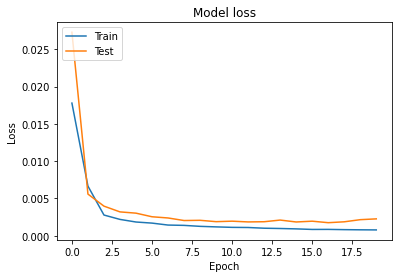

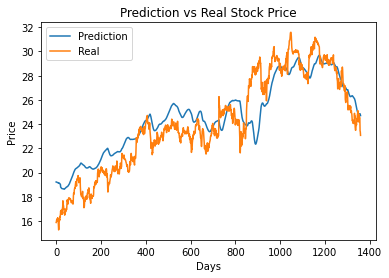

In [36]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime().replace(":","_")+'.png'))

# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime().replace(":","_")+'.png'))
# print_time("program completed ", stime)


![image.png](attachment:image.png)

In [34]:
len(df_esv_data[df_esv_data['Date']<'2018-01-01'])

251